## Import Libraries

In [123]:
#general utils library
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# plotting library
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# import gensim model
from gensim.models import KeyedVectors

# import machine learning models
from sklearn.ensemble import  RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

# import evaluation metrics library
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

# deep learning library
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.optimizers import Adam, Nadam

# to ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [291]:
data_train="./Data/News_Train.tsv"
data_test="./Data/News_test.tsv"
preTrainedDataVectors = "./PreTrained/GoogleNews-vectors-negative300.bin"

## Load the training data

In [325]:
columns=["ID","sentence","start","end","word","native","non-native","native-hard","non-native-hard","class","prob"]
dataTrain=pd.read_csv(data_train,header=None,sep="\t",names=columns)

In [6]:
dataTrain.head()

,ID,sentence,start,end,word,native,non-native,native-hard,non-native-hard,class,prob
0,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",4,10,barren,10,10,6,2,1,0.40
1,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",4,18,barren islands,10,10,0,1,1,0.05
2,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",20,25,reefs,10,10,1,2,1,0.15
3,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",11,18,islands,10,10,0,0,0,0.00
4,3P7RGTLO6EE07HLUVDKKHS6O7CCKA5,"The barren islands, reefs and coral outcrops a...",30,35,coral,10,10,0,0,0,0.00


## EDA

### Check for null values

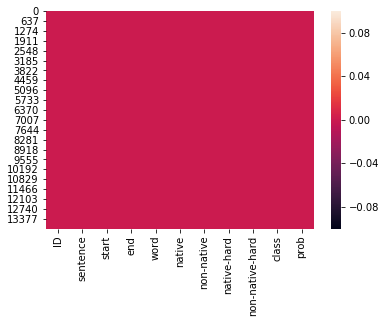

In [18]:
sns.heatmap(dataTrain.isnull())

### Check for balanced data or not

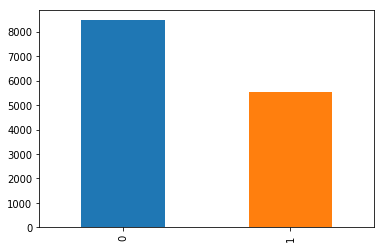

In [20]:
dataTrain["class"].value_counts().plot(kind='bar')

In [23]:
'''
    Function to plot word cloud from a pandas series
    Input: data: pandas.core.series.Series object
    Output: Wordcloud of most recurrent words in data
        for plots to be in ipython notebook include following line before calling this function
        %matplotlib inline '''
def plot_word_cloud(data):
    # take relative word frequencies into account, lower max_font_size
    wordcloud = WordCloud(max_font_size=40, relative_scaling=.5).generate(str(data))
    plt.figure()
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

## Visualization

Word Cloud for Easy Words


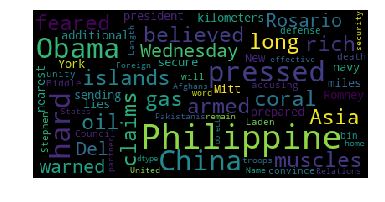

In [27]:
print("Word Cloud for Easy Words")
plot_word_cloud(dataTrain["word"].loc[dataTrain["class"] == 0,])

Word Cloud for Hard Words


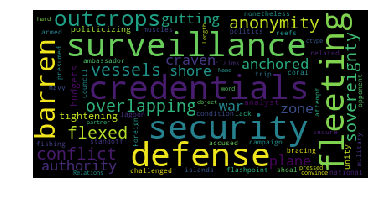

In [26]:
print("Word Cloud for Hard Words")
plot_word_cloud(dataTrain["word"].loc[dataTrain["class"] == 1,])

## Load a pre-trained Word2Vec trained on Google News Dataset
We used this because our data is also from news.So words used will be in similar context

In [183]:
#pretrained model downloaded in my system[size 1.5gb]
model = KeyedVectors.load_word2vec_format(preTrainedDataVectors, encoding="ISO-8859-1", binary=True)

In [91]:
#check the model
model["easy"].shape

(300,)

In [326]:
data_embeddings = []
count=0
for index, word in enumerate(dataTrain["word"]):
    words = []
    if word in model:
        words.append(model[word])
    if len(words) == 0:
        words.append(model['unk'])
        count+=1
    data_embeddings.append(np.average(words, axis=0))

## Define a train test Dataset

In [327]:
Xtrain = np.array(data_embeddings)
Ytrain = dataTrain["class"]

In [328]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(Xtrain, Ytrain, test_size=0.20, random_state=42)

## Baseline Model: Logistic Regression

In [296]:
LRModel = LogisticRegression()
LRModel.fit(Xtrain, Ytrain)
pred= LRModel.predict(Xtest)
print("Classification report")
print(classification_report(Ytest, pred))

Classification report
              precision    recall  f1-score   support

           0       0.87      0.83      0.85      1713
           1       0.75      0.81      0.78      1088

    accuracy                           0.82      2801
   macro avg       0.81      0.82      0.81      2801
weighted avg       0.82      0.82      0.82      2801



## Decision Tree Classifier

In [297]:
treeModel = DecisionTreeClassifier()
treeModel.fit(Xtrain, Ytrain)
pred= treeModel.predict(Xtest)
print("Classification report")
print(classification_report(Ytest, pred))

Classification report
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      1713
           1       0.76      0.79      0.77      1088

    accuracy                           0.82      2801
   macro avg       0.81      0.81      0.81      2801
weighted avg       0.82      0.82      0.82      2801



## Random Forest Classifier

In [298]:
rftreeModel = RandomForestClassifier()
rftreeModel.fit(Xtrain, Ytrain)
pred= rftreeModel.predict(Xtest)
print("Classification report")
print(classification_report(Ytest, pred))

Classification report
              precision    recall  f1-score   support

           0       0.88      0.84      0.86      1713
           1       0.76      0.81      0.79      1088

    accuracy                           0.83      2801
   macro avg       0.82      0.83      0.82      2801
weighted avg       0.83      0.83      0.83      2801



## Neural Network

In [329]:
def create_nn():
    """Create a simple neural network"""    
    model = Sequential()
    model.add(Dense(100, input_shape=(300,), activation='relu'))
    model.add(Dense(100, input_shape=(300,), activation='relu'))
    model.add(Dropout(rate=0.3))
    model.add(Dense(100, input_shape=(300,), activation='relu'))
    model.add(Dense(100, input_shape=(300,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [330]:
nnModel = create_nn()
optimizer = Nadam(lr=2e-3, beta_1=0.9, beta_2=0.999, schedule_decay=0.004)
nnModel.compile(optimizer="adam",
              loss='binary_crossentropy',
              metrics=["accuracy"])

nnModel.fit(
    Xtrain,
    Ytrain,
    validation_data=(Xtest, Ytest),
    epochs=25,
    batch_size=32)

Train on 11201 samples, validate on 2801 samples
Epoch 1/25
11201/11201 [==============================] - 2s 217us/step - loss: 0.4612 - acc: 0.7881 - val_loss: 0.3841 - val_acc: 0.8354
Epoch 2/25
11201/11201 [==============================] - 1s 107us/step - loss: 0.3618 - acc: 0.8484 - val_loss: 0.3773 - val_acc: 0.8368
Epoch 3/25
11201/11201 [==============================] - 1s 107us/step - loss: 0.3278 - acc: 0.8635 - val_loss: 0.3646 - val_acc: 0.8443
Epoch 4/25
11201/11201 [==============================] - 1s 103us/step - loss: 0.3047 - acc: 0.8762 - val_loss: 0.3665 - val_acc: 0.8479
Epoch 5/25
11201/11201 [==============================] - 1s 103us/step - loss: 0.2841 - acc: 0.8833 - val_loss: 0.3700 - val_acc: 0.8472
Epoch 6/25
11201/11201 [==============================] - 1s 108us/step - loss: 0.2703 - acc: 0.8847 - val_loss: 0.3723 - val_acc: 0.8479
Epoch 7/25
11201/11201 [==============================] - 1s 104us/step - loss: 0.2650 - acc: 0.8877 - val_loss: 0.3874 - v

In [331]:
pred = nnModel.predict(Xtest)
pred =  trypred.flatten()
binaryPred= np.where(pred<0.5,0,1)
print("Classification report NN")
print(classification_report(Ytest, binaryPred))

Classification report NN
              precision    recall  f1-score   support

           0       0.90      0.85      0.87      1713
           1       0.78      0.85      0.81      1088

    accuracy                           0.85      2801
   macro avg       0.84      0.85      0.84      2801
weighted avg       0.85      0.85      0.85      2801



### We get 89% accuracy in trainind data  and 84% in validation dataset and F1 score 84%.

## Predicting the result for Test File

In [332]:
columns=["ID","sentence","start","end","word","native","non-native"]
dataTest=pd.read_csv("./Data/News_test.tsv",header=None,sep="\t",names=columns)

In [302]:
dataTest.head()

,ID,sentence,start,end,word,native,non-native
0,3Z8UJEJOCZEG603II1EL4BE2PV593A,Syrian troops shelled a rebel-held town on Mon...,7,13,troops,10,10
1,3Z8UJEJOCZEG603II1EL4BE2PV593A,Syrian troops shelled a rebel-held town on Mon...,0,6,Syrian,10,10
2,3Z8UJEJOCZEG603II1EL4BE2PV593A,Syrian troops shelled a rebel-held town on Mon...,14,21,shelled,10,10
3,3Z8UJEJOCZEG603II1EL4BE2PV593A,Syrian troops shelled a rebel-held town on Mon...,24,34,rebel-held,10,10
4,3Z8UJEJOCZEG603II1EL4BE2PV593A,Syrian troops shelled a rebel-held town on Mon...,51,59,sparking,10,10


Word Cloud for Prediction Words


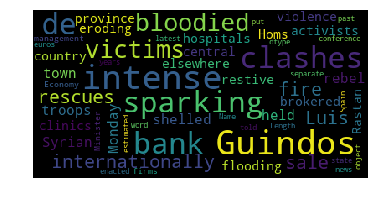

In [221]:
print("Word Cloud for Prediction Words")
plot_word_cloud(dataTest["word"])

In [333]:
#test data embedding
testdata_embeddings = []
for index, word in enumerate(dataTest["word"]):
    words = []
    if word in model:
        words.append(model[word])
    if len(words) == 0:
        count+=1
        words.append(model['unk'])
    testdata_embeddings.append(np.average(words, axis=0))

In [334]:
testdata =  np.array(testdata_embeddings)
pred = nnModel.predict(testdata)
pred =  pred.flatten()

In [335]:
# map result to 0,1 with threshold of 0.5
binaryPred= np.where(pred<0.5,0,1)

In [345]:
#save to csv
pd.Series(binaryPred).to_csv('test_prediction.csv',index=False)
# read back the csv
#pred=pd.read_csv("test_prediction.csv",header=None)

### That's All. Hope you liked it :)

### Things To Do next:
   #### Train the word embedding model on your own data[Currently didn't do it to same time for POC]
   #### Can also try Character Embedding which works better for OOV and infrequent words
    